In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from PIL import Image, ImageDraw
import cv2
import time

from landmark_detector import KeypointDetector
from face_detector import FaceDetector
# this face detector is taken from here
# https://github.com/TropComplique/FaceBoxes-tensorflow
# (facial keypoints detector is trained to work well with this detector)

# Load models

In [3]:
keypoint_detector = KeypointDetector('model.pb', gpu_memory_fraction=0.25, visible_device_list='0')
face_detector = FaceDetector('faceboxes.pb', visible_device_list='0')

In [4]:
def detect_faces_and_keypoints(image_array):
    """
    Arguments:
        image_array: a numpy uint8 array that represents RGB image.
    """
    
    H, W, _ = image_array.shape
    raw_boxes, _ = face_detector(image_array, score_threshold=0.5)
    
    crops = []
    boxes = []
    for box in raw_boxes:
        ymin, xmin, ymax, xmax = box
        h, w = ymax - ymin, xmax - xmin
        margin_y, margin_x = h / 6.0, w / 6.0  # 6.0 here is a hyperparameter
        ymin, xmin = ymin - 0.5 * margin_y, xmin - 0.5 * margin_x
        ymax, xmax = ymax + 0.5 * margin_y, xmax + 0.5 * margin_x
        ymin, xmin = np.maximum(int(ymin), 0), np.maximum(int(xmin), 0)
        ymax, xmax = np.minimum(int(ymax), H), np.minimum(int(xmax), W)
    
        crop = image_array[ymin:ymax, xmin:xmax, :]
        crops.append(cv2.resize(crop, (64, 64)))
        boxes.append([ymin, xmin, ymax, xmax])
    
    crops = np.stack(crops, axis=0)
    landmarks = keypoint_detector(crops)
    return boxes, landmarks

# Show detections

In [5]:
def draw_on_image(image, keypoints, boxes):

    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy, 'RGBA')
    
    for box, points in zip(boxes, keypoints):
    
        ymin, xmin, ymax, xmax = box
        h, w = ymax - ymin, xmax - xmin
        scaler = np.array([h, w])
        points = (points*scaler) + box[:2]

        fill = (255, 0, 0, 45)
        outline = 'red'
        draw.rectangle(
            [(xmin, ymin), (xmax, ymax)],
            fill=fill, outline=outline
        )

        for y, x in points:
            s = 2.0
            draw.ellipse([
                (x - s, y - s),
                (x + s, y + s)
            ], outline='blue')

    return image_copy

In [6]:
image_array = cv2.imread('the_office.jpg')
image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
print('image shape is', image_array.shape)

boxes, landmarks = detect_faces_and_keypoints(image_array)

image shape is (534, 950, 3)


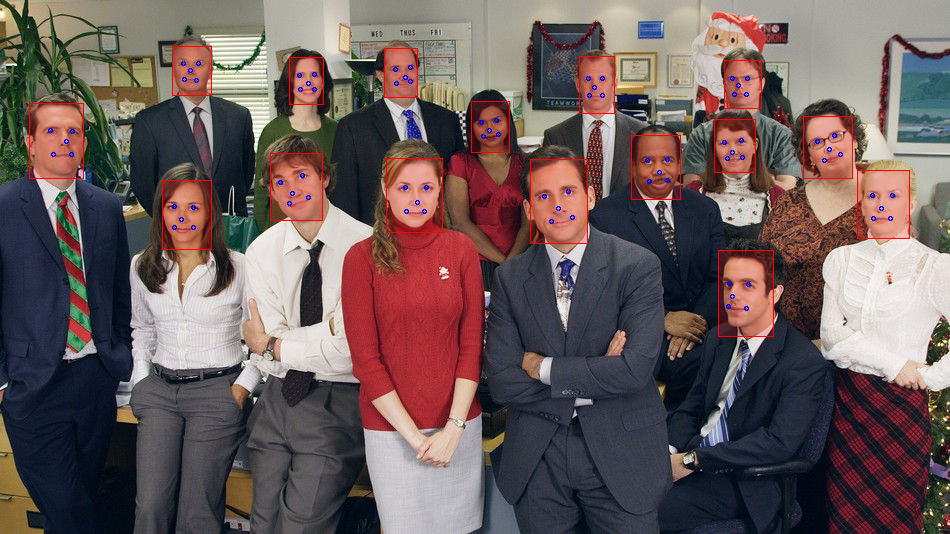

In [7]:
image = Image.fromarray(image_array)
result = draw_on_image(image, landmarks, boxes)
result

# Measure speed

In [8]:
batch_size = 8
crops = np.random.randint(0, 255, size=(batch_size, 64, 64, 3), dtype='uint8')

times = []
for _ in range(1100):
    start = time.perf_counter()
    _ = keypoint_detector(crops)
    times.append(time.perf_counter() - start)
    
times = np.array(times)
times = times[10:]
print(times.mean() / batch_size)

0.00014893506950519364
